# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Dataset: QC'd TF KO (and NTC) dataset
-  Analysis: pseudobulk differential expression analysis (DEA), pairwise Pearson correlation matrix, minimum distortion embedding (MDE)
***

# Import statements

In [7]:
# import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
# import networkx as nx
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.ds import DeseqStats
# from pydeseq2.default_inference import DefaultInference
import pickle as pkl
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
from biothings_client import get_client
import decoupler as dc
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# Differential expression analysis (DEA) on TF KO and NTC dataset (with lowly expressed genes filtered out) for downstream analysis

The DE results will be used for pre-ranked GSEA, so DEA must be run with LFC shrinkage and with all results saved (not just DEGs with p-adj > 0.05). The following DEA code (modified from Mali lab code) was tested in the `tf_project_testing` notebook. 

We will also remove lowly expressed genes: 30% of genes with lowest expression (normalized and log1p-transformed) in TF KO cells and genes expressed in fewer than 100 TF KO cells. This was tested in the `tf_project_mde_tests` notebook.

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Genes that passed filtering out lowly expressed genes
genes_to_keep = pd.read_pickle("/home/ranwyl/data_tf_project/genes_filt_30pct_100cells.pkl")
genes_to_keep = genes_to_keep[0].tolist()

In [3]:
# Function to filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def pre_DE_analysis(adata, genes_to_keep_list):
    """
    Prepare dataset for differential expression analysis using PyDESeq2.
    """
    # Filter TF KO and NTC cells
    adata = filter_tf_ko_and_ntc(adata)
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()
    # Remove lowly expressed genes
    adata = adata[:,adata.var.index.isin(genes_to_keep_list)].copy()
    return adata

Run DEA with lfc_shrink(adapt=False)

In [4]:
def tf_pseudo_bulk_replicates_for_DE(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified to manually set NTC as reference for differential expression analysis.
    """
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=8):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]", adapt=False) 
    results = stat_res.results_df
    return results


def tf_run_deseq2_analysis(adata, n_cpus=8, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                            n_replicates=3, sample_fraction=0.85, layer=None, alpha=0.05):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = tf_pseudo_bulk_replicates_for_DE(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, 
            sample_fraction=sample_fraction, layer=layer
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [7]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha

AnnData object with n_obs × n_vars = 84485 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [8]:
adata_alpha = pre_DE_analysis(adata_alpha, genes_to_keep)
adata_alpha.shape

(45429, 13792)

In [9]:
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, n_cpus=25)

Running DE analysis:   0%|          | 0/643 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserW

In [10]:
alpha_DE_df = tf_save_DE_df(results_dict_alpha)

In [11]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta = pre_DE_analysis(adata_beta, genes_to_keep)
results_dict_beta = tf_run_deseq2_analysis(adata_beta, n_cpus=25)
beta_DE_df = tf_save_DE_df(results_dict_beta)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [12]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma = pre_DE_analysis(adata_gamma, genes_to_keep)
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, n_cpus=25)
gamma_DE_df = tf_save_DE_df(results_dict_gamma)

Running DE analysis:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
aggregate_DE_df = pd.concat([alpha_DE_df, beta_DE_df, gamma_DE_df], axis=1)
aggregate_DE_df = aggregate_DE_df.sort_index()

In [14]:
aggregate_DE_df.head()

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   
AAAS             7.516582              0.150004     0.507604    0.353576   
AACS            13.652746             -0.607225     0.388791   -1.720363   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   
AAAS           0.723657         NaN       6.140222            -0.182040   
AACS           0.085366         NaN      11.690521             0.006217   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   
AAAS         0.560998  -0.406698  ...     0.736081    0.548093      0.583628   
AACS         0.417831   0.015168  ...     0.694740    0.985767      0.324247   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   
AAAS              NaN          6.569917               -0.557903   
AACS              NaN          9.678652               -0.525741   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  
AAAS            0.565281     -1.206801        0.227509      0.894912  
AACS            0.473100     -1.283670        0.199258      0.893908  

[5 rows x 3912 columns]

In [15]:
filepath_pkl = "/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl"
aggregate_DE_df.to_pickle(filepath_pkl)

In [4]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")
de_results

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   
AAAS             7.516582              0.150004     0.507604    0.353576   
AACS            13.652746             -0.607225     0.388791   -1.720363   
...                   ...                   ...          ...         ...   
ZYG11A           1.936280              0.399434     0.914994    0.746997   
ZYG11B          18.247310              0.038689     0.334166    0.123994   
ZYX             22.916347              0.018090     0.297322    0.063336   
ZZEF1            5.599009             -0.137232     0.571315   -0.304019   
ZZZ3            25.307732             -0.080898     0.291180   -0.296541   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   
AAAS           0.723657         NaN       6.140222            -0.182040   
AACS           0.085366         NaN      11.690521             0.006217   
...                 ...         ...            ...                  ...   
ZYG11A         0.455065         NaN       0.847039            -1.352335   
ZYG11B         0.901320         NaN      12.379707            -0.510436   
ZYX            0.949499         NaN      15.218808             0.244391   
ZZEF1          0.761113         NaN       6.190842             0.929886   
ZZZ3           0.766817         NaN      15.362206            -0.050057   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   
AAAS         0.560998  -0.406698  ...     0.736081    0.548093      0.583628   
AACS         0.417831   0.015168  ...     0.694740    0.985767      0.324247   
...               ...        ...  ...          ...         ...           ...   
ZYG11A       1.868836  -1.441918  ...     1.138496    0.365796      0.714517   
ZYG11B       0.415147  -1.377508  ...     0.500329   -0.321024      0.748192   
ZYX          0.373242   0.721548  ...     0.688878    0.004616      0.996317   
ZZEF1        0.618079   1.848373  ...     0.814633   -0.411803      0.680484   
ZZZ3         0.373907  -0.149499  ...     0.426299    0.282433      0.777612   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   
AAAS              NaN          6.569917               -0.557903   
AACS              NaN          9.678652               -0.525741   
...               ...               ...                     ...   
ZYG11A            NaN          0.821237               -0.151334   
ZYG11B            NaN         15.932747               -0.174367   
ZYX               NaN         16.135930                0.426690   
ZZEF1             NaN          5.908567               -0.227841   
ZZZ3              NaN         27.742781                0.377662   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  
AAAS            0.565281     -1.206801        0.227509      0.894912  
AACS            0.473100     -1.283670        0.199258      0.893908  
...  

### Rename genes by Ensembl ID

In [5]:
all_genes = de_results.index.tolist()
ensg_genes = [g for g in all_genes if g.startswith("ENSG")]
print(len(ensg_genes))
print(ensg_genes[:5])

838
['ENSG00000170846', 'ENSG00000176593', 'ENSG00000179066', 'ENSG00000183308', 'ENSG00000187186']


In [6]:
mg = get_client('gene')

In [7]:
ensembl_results_all = mg.querymany(ensg_genes, fields='symbol', species='human')

Input sequence provided is already in string format. No operation performed
4 input query terms found dup hits:	[('ENSG00000228566', 2), ('ENSG00000234352', 2), ('ENSG00000249738', 2), ('ENSG00000257545', 2)]
66 input query terms found no hit:	['ENSG00000214955', 'ENSG00000228434', 'ENSG00000228648', 'ENSG00000229191', 'ENSG00000234405', 'ENS


Manually search for the 4 genes with duplicate hits on GeneCards. To break ties, use the highest GeneCards Inferred Functionality Score (GIFtS). If there is a tie between highest scoring gene symbols, keep the gene as its Ensembl ID.

In [8]:
dup_hits = {'ENSG00000234352': 'LOC349160', 'ENSG00000249738':'IL12B-AS1', 'ENSG00000257545':'LOC100287944'}

Rename genes

In [9]:
ensembl_to_gene = dict()
for r in ensembl_results_all:
  if r.get('symbol'):
      ensembl_to_gene[r.get('query')] = r.get('symbol')
print(len(ensembl_to_gene))

186


In [10]:
ensembl_to_gene.update(dup_hits)
print(len(ensembl_to_gene))

186


In [13]:
# Rename genes in DataFrame
def rename_ensembl_genes(de_df, ensembl_to_gene_dict):
    de_df_renamed = de_df.rename(index=ensembl_to_gene_dict)
    print(f"Converted {len(ensembl_to_gene_dict)} Ensembl IDs to gene symbols")
    return de_df_renamed

In [14]:
de_results_renamed = rename_ensembl_genes(de_results, ensembl_to_gene)

Converted 186 Ensembl IDs to gene symbols


Write out results

In [15]:
de_results.to_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_gene_symbols.pkl")

# Post-DEA QC/preprocessing

### Normalization, log1p transformation, and batch correction on TF KO & NTC dataset

In [9]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [10]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

In [ ]:
# Filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

# Remove lowly expressed genes based on list
def filter_low_expr_genes(adata, genes_to_keep_list):
    return adata[:,adata.var.index.isin(genes_to_keep_list)].copy()

def filter_cells_and_genes(adata, genes_to_keep_list):
    adata = filter_tf_ko_and_ntc(adata)
    return filter_low_expr_genes(adata, genes_to_keep_list)

# Genes that passed filtering out lowly expressed genes
genes_to_keep = pd.read_pickle("/home/ranwyl/data_tf_project/genes_filt_30pct_100cells.pkl")
genes_to_keep = genes_to_keep[0].tolist()

In [15]:
adata_alpha_filtered = filter_cells_and_genes(adata_alpha, genes_to_keep)
adata_beta_filtered = filter_cells_and_genes(adata_beta, genes_to_keep)
adata_gamma_filtered = filter_cells_and_genes(adata_gamma, genes_to_keep)

In [16]:
adata_combined = ad.concat([adata_alpha_filtered, adata_beta_filtered, adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()
adata_combined

AnnData object with n_obs × n_vars = 69241 × 13792
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

Normalization to median UMI count of all NTC cells

In [17]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)

normalizing counts per cell
    finished (0:00:00)


Log1p transformation and batch correction

In [18]:
sc.pp.log1p(adata_combined)
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()

In [19]:
qc2.relative_z_normalization(a)
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)
normalized_adata = ad.concat([a,b,c])
normalized_adata

AnnData object with n_obs × n_vars = 69241 × 13792
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [23]:
normalized_adata.write("/home/ranwyl/data_tf_project/Final_Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

# Preprocessing

## Data read-in

In [2]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Final_Aggregate_TF_KO_Batch_Normalized.h5ad")

In [4]:
adata_tfs

AnnData object with n_obs × n_vars = 31808 × 13792
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Read in set of TFs

In [3]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in differential expression analysis results from TF KO and NTC dataset (lowly expressed genes from TF KO dataset filtered out, 85% sample fraction, LFC shrinkage performed with adapt=False)

In [3]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [27]:
de_results.head()

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   
AAAS             7.516582              0.150004     0.507604    0.353576   
AACS            13.652746             -0.607225     0.388791   -1.720363   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   
AAAS           0.723657         NaN       6.140222            -0.182040   
AACS           0.085366         NaN      11.690521             0.006217   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   
AAAS         0.560998  -0.406698  ...     0.736081    0.548093      0.583628   
AACS         0.417831   0.015168  ...     0.694740    0.985767      0.324247   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   
AAAS              NaN          6.569917               -0.557903   
AACS              NaN          9.678652               -0.525741   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  
AAAS            0.565281     -1.206801        0.227509      0.894912  
AACS            0.473100     -1.283670        0.199258      0.893908  

[5 rows x 3912 columns]

In [28]:
de_results.shape

(13792, 3912)

## Filter TF KO cells

Read in batch-corrected TF KO and NTC dataset

In [29]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Final_Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

Filter TF KO cells

In [30]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
print(f"number of cells after filtering: {adata_tfs.obs.shape[0]}")

number of cells before filtering: 69241
number of cells after filtering: 31808


In [31]:
adata_tfs

AnnData object with n_obs × n_vars = 31808 × 13792
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [32]:
adata_tfs.write_h5ad("/home/ranwyl/data_tf_project/Final_Aggregate_TF_KO_Batch_Normalized.h5ad")

### Display TF KO info and plot histogram

Number of unique TF KOs

In [18]:
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

652


Save list of unique TF KOs as a .txt file

In [ ]:
with open("/home/ranwyl/results_tf_project/tf_list_652.txt", "w") as f:
    for tf in unique_tfs:
        f.write(f"{tf}\n")

Number of cells per TF KO

In [19]:
cells_per_tf_ko = adata_tfs.obs['gene_target'].value_counts()

In [20]:
print(cells_per_tf_ko[:5])

gene_target
ZFP41       209
ARHGAP35    186
DNMT1       150
ZNF354A     139
BHLHE40     139
Name: count, dtype: int64


In [ ]:
def plot_cells_per_tf_ko(cells_per_tf_ko_value_counts, n_bins=30, x_label=None):
    ax = sns.histplot(cells_per_tf_ko_value_counts.values, bins=n_bins)
    if x_label == None:
        x_label = "Cells per TF KO"
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

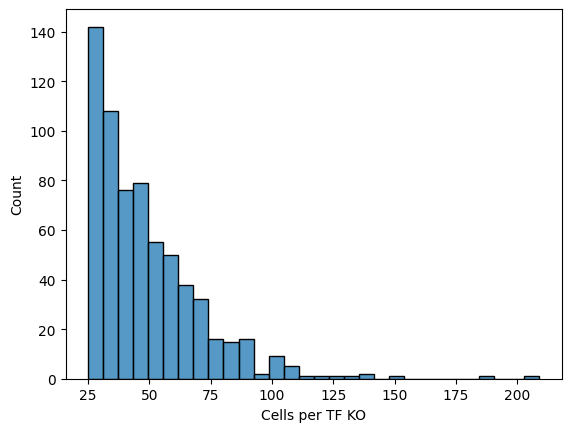

In [21]:
ax = sns.histplot(cells_per_tf_ko.values, bins=30)
p = plt.xlabel("Cells per TF KO")

In [3]:
def cells_per_batch(adata, dataset_name):
    for run in "ALPHA", "BETA", "GAMMA":
        print(f"In {dataset_name}, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

# Feature selection

## HVGs

### Filter genes to 2000 HVGs

In [5]:
adata_hvgs = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_hvgs, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [6]:
adata_hvgs

AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [11]:
hvgs_final_list = adata_hvgs.var.index.tolist()
hvgs_final_list.sort()

In [15]:
with open("/home/ranwyl/results_tf_project/hvgs_final.txt", "w") as f:
    for hvg in hvgs_final_list:
        f.write(f"{hvg}\n")

In [12]:
hvgs = set(hvgs_final_list)

## DEGs with p-adj < 0.05

Write function to get set of DEGs that pass given LFC threshold and p-adj threshold based on DE results

In [5]:
def filter_degs_lfc_padj(deg_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs_set = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs_set.update(deg_df.loc[(abs(deg_df[l2fc_col]) > lfc_threshold) 
                                   & (deg_df[padj_col] < padj_threshold)].index)
    return lfc_degs_set

Generate set of DEGs with |LFC| > 0.25 and p-adj < 0.05

In [6]:
degs_padj = filter_degs_lfc_padj(de_results)
print(len(degs_padj))

4265


In [7]:
adata_tfs_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_padj)].copy()
adata_tfs_degs

AnnData object with n_obs × n_vars = 31808 × 4265
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [10]:
adata_degs_padj = adata_tfs_degs

Save p-adj DEG list

In [50]:
degs_padj_final_list = sorted(list(degs_padj))
with open("/home/ranwyl/results_tf_project/degs_padj_final.txt", "w") as f:
    for deg in degs_padj_final_list:
        f.write(f"{deg}\n")

Sizes of intersection and union with HVGs

In [13]:
print(f"DEG HVG intersection: {len(degs_padj.intersection(hvgs))} genes")
print(f"DEG HVG union: {len(degs_padj.union(hvgs))} genes")

DEG HVG intersection: 1325 genes
DEG HVG union: 4940 genes


### Test different LFC thresholds

In [14]:
def filter_degs_lfc_padj(deg_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(deg_df.loc[(abs(deg_df[l2fc_col]) > lfc_threshold) 
                                   & (deg_df[padj_col] < padj_threshold)].index)
    return lfc_degs

def test_n_degs(de_results, padj_thr):
    n_degs_list = list()
    lfc_thr_list = [0, 0.25, 0.5, 0.75, 1, 1.5, 2]
    for lfc_thr in lfc_thr_list:
        n_degs_list.append(len(filter_degs_lfc_padj(de_results, lfc_thr, padj_thr)))
    return lfc_thr_list, n_degs_list

def plot_n_degs(lfc_thr_list, n_degs_list, title, ymax=None):
    ax = sns.lineplot(x=lfc_thr_list, y=n_degs_list, marker="o")
    plt.xlabel("|LFC| Threshold", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.title(title, fontsize=14)
    plt.grid()

For p-adj < 0.05

In [15]:
lfc_thresholds, n_degs_0pt05 = test_n_degs(de_results, 0.05)

In [25]:
print(lfc_thresholds)
print(n_degs_0pt05)

[0, 0.25, 0.5, 0.75, 1, 1.5, 2]
[4265, 4265, 4214, 3647, 2718, 1356, 707]


In [43]:
#plot_n_degs(lfc_thresholds, n_degs_0pt05, "Number of DEGs vs. |LFC| Threshold (p-adj < 0.05)", ymax=5500)

For p-adj < 0.025

In [26]:
lfc_thresholds, n_degs_0pt02 = test_n_degs(de_results, 0.02)
print(n_degs_0pt02)

[2922, 2922, 2881, 2442, 1817, 972, 544]


For p-adj < 0.01

In [27]:
lfc_thresholds, n_degs_0pt01 = test_n_degs(de_results, 0.01)
print(n_degs_0pt01)

[2338, 2338, 2298, 1923, 1474, 825, 474]


In [44]:
#plot_n_degs(lfc_thresholds, n_degs_0pt01, "Number of DEGs vs. |LFC| Threshold (p-adj < 0.01)", ymax=3000)

In [32]:
def plot_n_degs_multi_line(x, y1, y2, y3, label1, label2, label3, title):
    plt.plot(x, y1, label=label1, marker=".", color="tab:red")
    plt.plot(x, y2, label=label2, marker=".", color="tab:green")
    plt.plot(x, y3, label=label3, marker=".", color="tab:blue")
    plt.xlabel("|LFC| Threshold", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

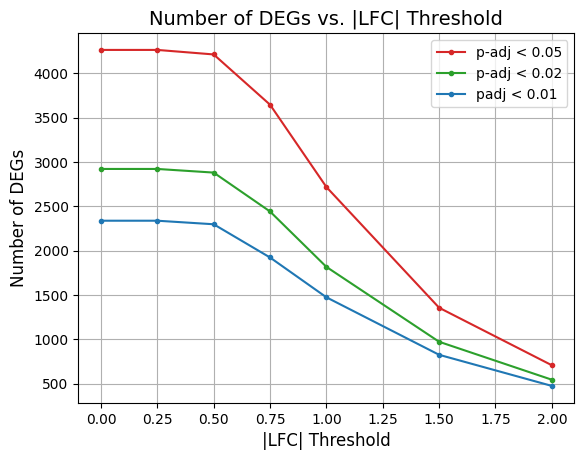

In [33]:
plot_n_degs_multi_line(x=lfc_thresholds, y1=n_degs_0pt05, y2=n_degs_0pt02, y3=n_degs_0pt01,
                       label1="p-adj < 0.05", label2="p-adj < 0.02", label3="padj < 0.01",
                       title="Number of DEGs vs. |LFC| Threshold")

## DEGs with p-value cutoff (decided p-val < 0.0005)

Write function to get set of DEGs that pass given LFC threshold and p-value threshold based on DE results

In [16]:
def filter_degs_lfc_pval(de_df, lfc_threshold=0.25, pval_threshold=0.05, tf_ko_list=None):
    if not tf_ko_list:
        # Get list of perturbations from column labels
        perts = {col.split("_")[0] for col in de_df.columns}
    else:
        perts = tf_ko_list
    # Get genes where |L2FC| > threshold and p-adj < threshold
    deg_set = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        pval_col = f"{pert}_pvalue"
        deg_set.update(de_df.loc[(abs(de_df[l2fc_col]) > lfc_threshold) 
                                   & (de_df[pval_col] < pval_threshold)].index)
    return deg_set

In [17]:
degs_pval = filter_degs_lfc_pval(de_results, pval_threshold=0.0005)
print(len(degs_pval))

4901


Save p-val DEG list

In [51]:
degs_pval_final_list = sorted(list(degs_pval))
with open("/home/ranwyl/results_tf_project/degs_pval_final.txt", "w") as f:
    for deg in degs_pval_final_list:
        f.write(f"{deg}\n")

Sizes of intersection and union with HVGs

In [40]:
print(f"DEG HVG intersection: {len(degs_pval.intersection(hvgs))} genes")
print(f"DEG HVG union: {len(degs_pval.union(hvgs))} genes")

DEG HVG intersection: 1354 genes
DEG HVG union: 5547 genes


### Test number of DEGs with |LFC| > 0.25 and different p-value thresholds

In [41]:
def test_n_degs_pval(de_df, lfc_thr, pval_thr_list):
    tf_kos = {col.split("_")[0] for col in de_df.columns}
    n_degs_list = list()
    for pval_thr in pval_thr_list:
        n_degs_list.append(len(filter_degs_lfc_pval(de_df, lfc_thr, pval_thr, tf_kos)))
    return n_degs_list

def plot_n_degs_pval(pval_thr_list, n_degs_list, title, ymax=None):
    ax = sns.lineplot(x=pval_thr_list, y=n_degs_list, marker="o")
    plt.xlabel("p-value Threshold", fontsize=14)
    plt.ylabel("Number of DEGs", fontsize=14)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.title(title, fontsize=15)
    plt.grid()

In [42]:
pval_thresholds = [0.0005, 0.001, 0.005, 0.01]
n_degs_pval = test_n_degs_pval(de_results, 0.25, pval_thresholds)

In [43]:
print(pval_thresholds)
print(n_degs_pval)

[0.0005, 0.001, 0.005, 0.01]
[4901, 6493, 10495, 11910]


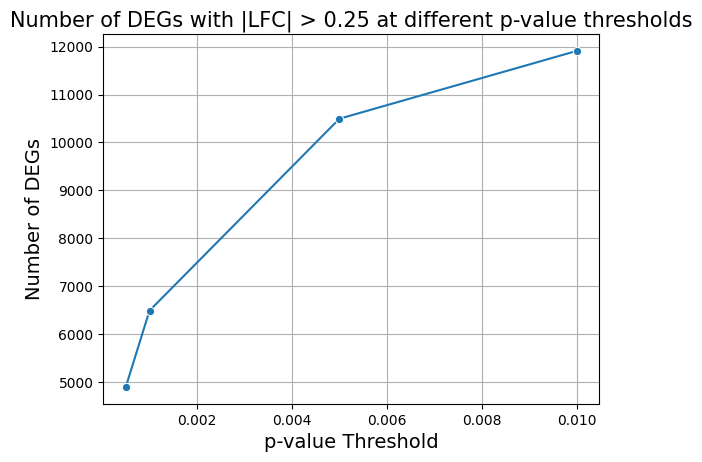

In [44]:
plot_n_degs_pval(pval_thresholds, n_degs_pval, 
                 "Number of DEGs with |LFC| > 0.25 at different p-value thresholds")

# Pairwise Pearson correlation matrix of mean profiles

In [8]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def tf_create_corrmatrix(adata, v_min=-1, v_max=1, color_map="RdBu"):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    adata_mean_profiles = [compute_mean_profile(adata, indices) for indices in gene_target_groups.values()]
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe, cmap=color_map, xticklabels=False, yticklabels=False, vmax=v_max, vmin=v_min, center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

### Pairwise Pearson correlation matrix of mean profiles for p-adj DEG dataset

In [ ]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")
with open("/home/ranwyl/results_tf_project/degs_padj_final.txt") as f:
    degs_padj = {deg.strip() for deg in f.readlines()}
adata_degs_padj = adata_tfs[:, adata_tfs.var.index.isin(degs_padj)].copy()
adata_degs_padj

AnnData object with n_obs × n_vars = 31808 × 5096
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


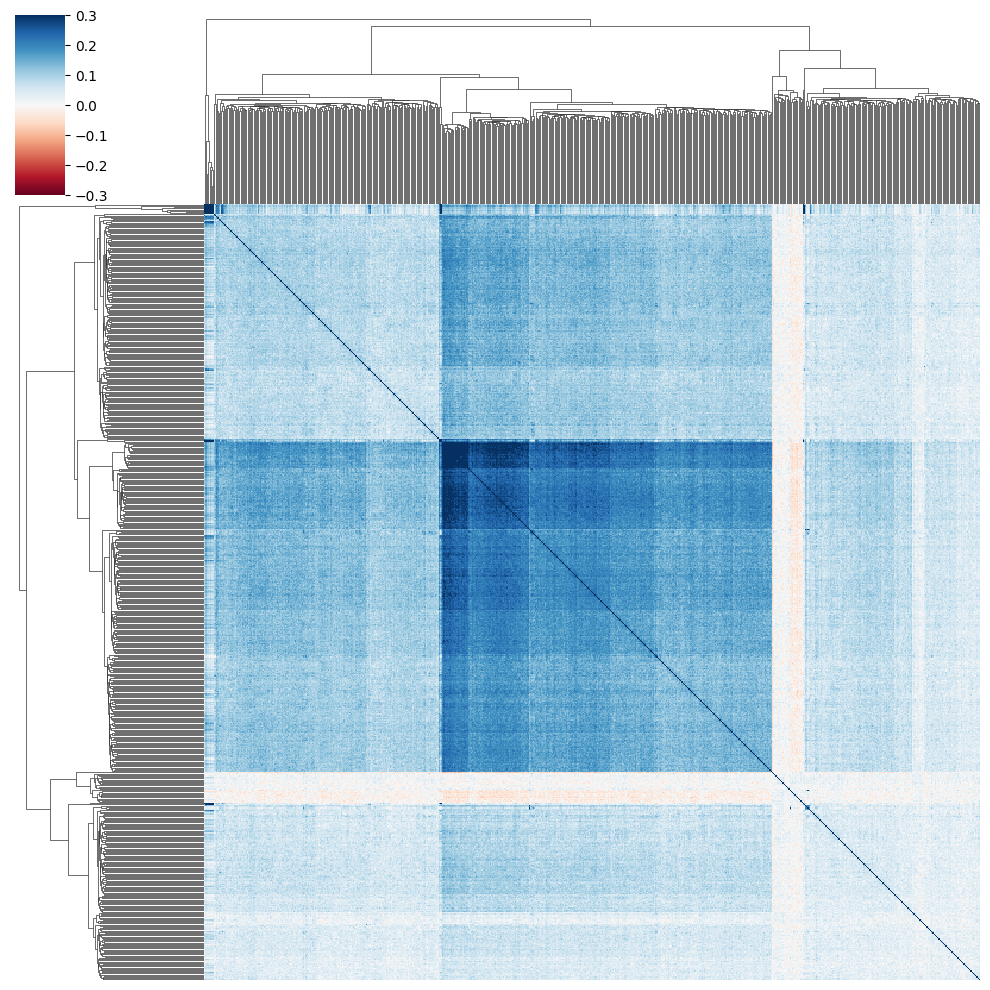

In [11]:
_ = tf_create_corrmatrix(adata_degs_padj, v_min=-0.3, v_max=0.3)

### Pairwise Pearson correlation matrix of mean profiles for p-val DEG dataset

In [ ]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [52]:
with open("/home/ranwyl/results_tf_project/degs_pval_final.txt") as f:
    degs_pval = {deg.strip() for deg in f.readlines()}
adata_degs_pval = adata_tfs[:, adata_tfs.var.index.isin(degs_pval)].copy()
adata_degs_pval

AnnData object with n_obs × n_vars = 31808 × 4901
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [12]:
# _ = tf_create_corrmatrix(adata_degs_pval, v_min=-0.3, v_max=0.3)

### Pairwise Pearson correlation matrix of mean profiles for 2000-HVG dataset

In [12]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [101]:
# _ = tf_create_corrmatrix(adata_2000, v_min=-0.3, v_max=0.3)

# Minimal Distortion Embedding (MDE)

### MDE functions

In [2]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Changed code to no longer compute mean normalized profiles in parallel -Robin
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    pymde.seed(42) # Added by Robin to make pymde.preserve_neighbors() deterministic
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack',
                random_state=42 # Added by Robin to make sklearn.SpectralEmbedding deterministic
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
                                         seed=42 # Added by Robin to make leidenalg.find_partition() deterministic
                                         )
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()

    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points: # Added by Robin
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array, embedding_df

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

def plot_n_perts_per_cluster(perts_in_cluster_df, title, ymax=50):
    n_perts_per_cluster = perts_in_cluster_df.nunique().tolist()
    xvals = [i for i in range(len(n_perts_per_cluster))]
    ax = sns.barplot(x=xvals, y=n_perts_per_cluster)
    ax.set_xlabel("Leiden cluster")
    ax.set_ylabel("Number of TF KOs in cluster")
    ax.set_ylim(0, ymax)
    ax.set_title(title)

### MDE with p-val DEGs as features

In [3]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [4]:
with open("/home/ranwyl/results_tf_project/degs_pval_final.txt") as f:
    degs_pval = {deg.strip() for deg in f.readlines()}
adata_degs_pval = adata_tfs[:, adata_tfs.var.index.isin(degs_pval)].copy()
adata_degs_pval

AnnData object with n_obs × n_vars = 31808 × 4901
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [14]:
# mde_degs_pval_8 = tf_compute_MDE(adata_degs_pval, label_points=False, spectral=True, leiden_neighbors=8)

In [45]:
# _, _, _, _, embedding_df_degs_pval_8 = mde_degs_pval_8
# perts_in_cluster_degs_pval_8 = gene_targets_per_cluster(embedding_df_degs_pval_8)
# perts_in_cluster_degs_pval_8.head()

In [43]:
# _ = plot_n_perts_per_cluster(perts_in_cluster_degs_pval_8, "TF KOs per cluster (DEGs with p-val threshold, 8 Leiden neighbors)")

In [ ]:
perts_in_cluster_degs_pval_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_degs_pval_8_nbrs.csv")

10 neighbors

In [15]:
# mde_degs_pval_10 = tf_compute_MDE(adata_degs_pval, label_points=False, spectral=True, leiden_neighbors=10)

In [44]:
# _, _, _, _, embedding_df_degs_pval_10 = mde_degs_pval_10
# perts_in_cluster_degs_pval_10 = gene_targets_per_cluster(embedding_df_degs_pval_10)
# _ = plot_n_perts_per_cluster(perts_in_cluster_degs_pval_10, 
#                              "TF KOs per cluster (DEGs with p-val threshold, 10 Leiden neighbors)")

In [ ]:
perts_in_cluster_degs_pval_10.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_degs_pval_10_nbrs.csv")

### MDE with p-adj DEGs as features

In [3]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")
with open("/home/ranwyl/results_tf_project/degs_padj_final.txt") as f:
    degs_padj = {deg.strip() for deg in f.readlines()}
adata_degs_padj = adata_tfs[:, adata_tfs.var.index.isin(degs_padj)].copy()
adata_degs_padj

AnnData object with n_obs × n_vars = 31808 × 4265
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Aug 07 05:28:44 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 133707 edges.
Aug 07 05:28:44 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Aug 07 05:28:44 PM: iteration 0000 | distortion 0.916276 | residual norm 0.0945157 | step length 0.376217 | percent change 0.09847
Aug 07 05:28:46 PM: iteration 0100 | distortion 0.134537 | residual norm 0.000146236 | step length 1 | percent change 1.02624
Aug 07 05:28:48 PM: iteration 0200 | distortion 0.132919 | residual norm 9.19412e-05 | step length 1 | percent change 0.147852
Aug 07 05:28:50 PM: iteration 0300 | distortion 0.132364 | residual norm 3.87945e-05 | step length 1 | percent change 0.224233
Aug 07 05:28:51 PM: Converged in 395 iterations, with residual norm 7.98684e-06
Aug 07 05:28:51 PM: Finished fitting in 7.600 seconds and 395 iterations.
Aug 07 05:28:51 PM: average distortion 0.132 | residual norm 8.0e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



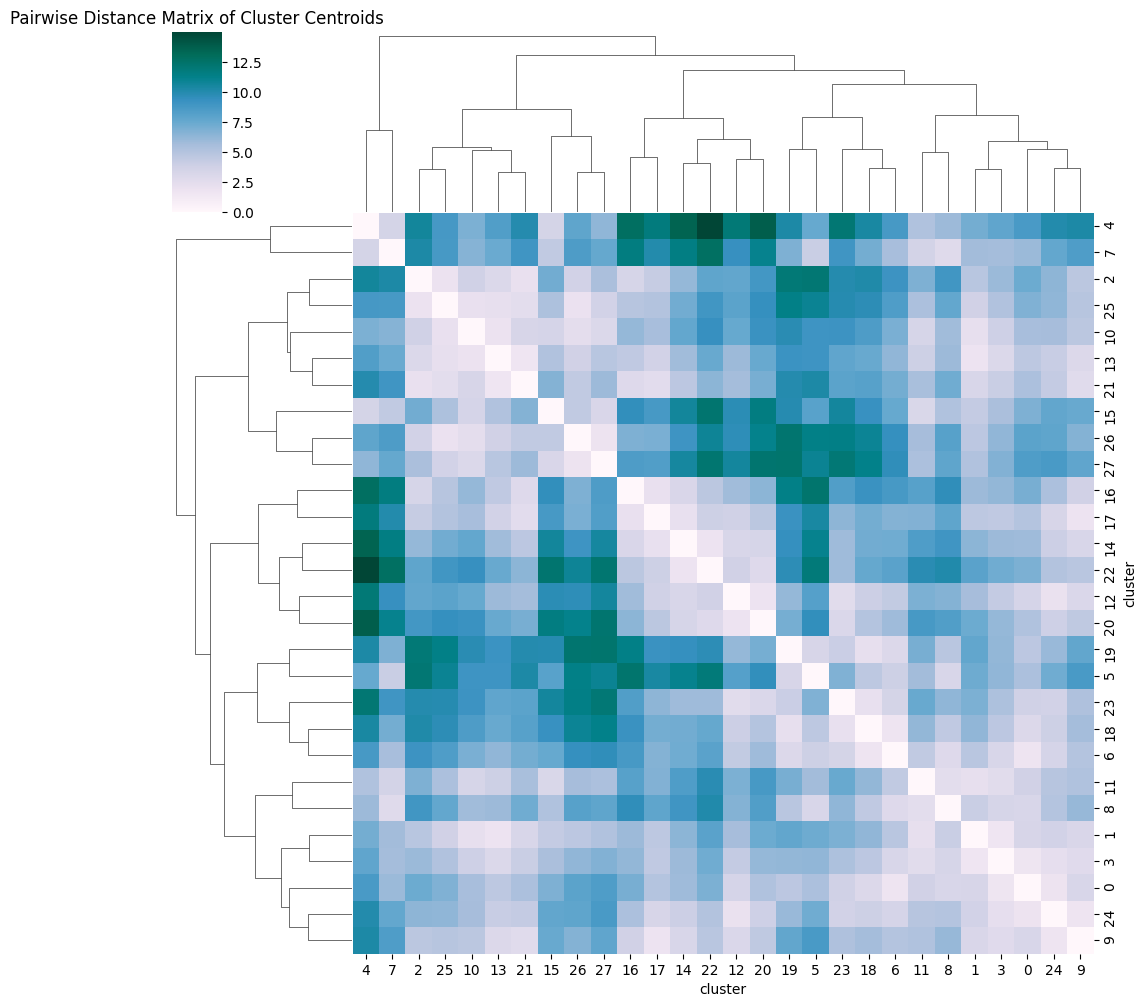

In [10]:
mde_degs_padj_8 = tf_compute_MDE(adata_degs_padj, label_points=False, spectral=True, leiden_neighbors=8)

In [6]:
_, _, _, _, embedding_df_degs_padj_8 = mde_degs_padj_8
embedding_df_degs_padj_8.head()

x         y gene_target cluster
0 -5.303793 -1.379072       ADNP2      15
1  4.759978 -4.013325       AEBP1      16
2 -0.863183 -6.309071         AHR       2
3 -2.841603 -2.751663        AIRE      10
4  7.480436 -1.027967       AKAP8      22

In [7]:
perts_in_cluster_degs_padj_8 = gene_targets_per_cluster(embedding_df_degs_padj_8)
perts_in_cluster_degs_padj_8.head()

0        1       2        3        4       5       6       7   \
0      ARX     CBX2     AHR    ATF6B    ASCL1   ATMIN    CDX1   BACH2   
1    ATOH1   CCDC17  ANKZF1   BHLHA9    ETV3L   CENPS    JRKL  CC2D1A   
2  BHLHE41  CREB3L3    ARNT  BHLHA15  FLYWCH1  CHAMP1   PITX2   CEBPB   
3     CREM    DMRT3   ARNT2      ERF    GTF3A  DMRTB1  POU4F3   CEBPD   
4   DMRTC2     ESR1  CAMTA2     FOSB     HMX2   DNMT1  RHOXF2    DLX2   

        8        9   ...     18     19       20       21        22       23  \
0   ARID3A    CEBPA  ...  ESRRG    BSX    ATOH7    CTCFL     AKAP8  FOXD4L5   
1    BARX1  CREB3L4  ...  FOXJ2  DOT1L    DMBX1    DACH2  ARHGAP35     MITF   
2  BHLHE40     ETV1  ...    HDX   HES7  FAM200B    FOXE3     CXXC1    NFXL1   
3    CREB5    FOXS1  ...   IRF9   JUNB    FOXN4  GATAD2A      KLF4     RORC   
4    ESRRA    GATA3  ...  KLF15   MAFK  NEUROD2    GRHL2     KLF10    TBX18   

       24      25     26        27  
0  CREBL2     CRX  ASCL2      EBF2  
1  DMRTA2   GLIS3  CENPX     GMEB2  
2   SMAD4   GTF2I   DLX4  GTF2IRD1  
3   STAT6  TCF7L1  DMRT2     NFKB1  
4  ZNF75D   TIGD2   HSF2    SNAPC4  

[5 rows x 28 columns]

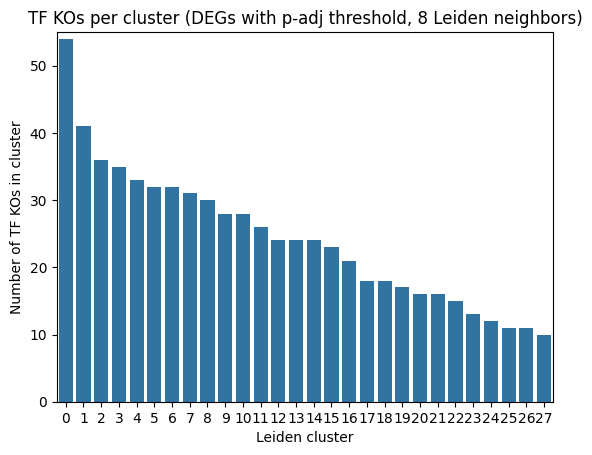

In [9]:
_ = plot_n_perts_per_cluster(perts_in_cluster_degs_padj_8, 
                             "TF KOs per cluster (DEGs with p-adj threshold, 8 Leiden neighbors)",
                             ymax=55)

In [11]:
perts_in_cluster_degs_padj_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_4265degs_padj_8nbrs.csv")

10 neighbors

In [9]:
# mde_5087_10 = tf_compute_MDE(adata_5087, label_points=False, spectral=True, leiden_neighbors=10)

In [99]:
# _, _, _, _, embedding_df_5087_10 = mde_5087_10
# perts_in_cluster_5087_10 = gene_targets_per_cluster(embedding_df_5087_10)
# _ = plot_n_perts_per_cluster(perts_in_cluster_5087_10, "TF KOs per cluster (5087-DEG dataset, 10 Leiden neighbors)")

### MDE on 2000 HVG dataset

In [7]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [96]:
# mde_2000_8 = tf_compute_MDE(adata_2000, label_points=False, spectral=True, leiden_neighbors=8)

In [20]:
_, _, _, _, embedding_df_2000_8 = mde_2000_8
perts_in_cluster_2000_8 = gene_targets_per_cluster(embedding_df_2000_8)
perts_in_cluster_2000_8.head()

0        1      2       3        4       5         6        7   \
0    AEBP1    ARID2  ATF6B   CREB5      ARX  CC2D1A  ARHGAP35    AKAP8   
1    ATOH7    BCL6B   ESR2   DMRT2    ASCL5   CEBPA     ARNT2  BHLHE40   
2    BACH2  BHLHE41  FOXE3  DMRTB1   BARHL1   CEBPE     BARX1     CBX2   
3  CREB3L4    DMRT3  FOXJ1    ETV5  BHLHA15    DBX2     CTCFL    CEBPD   
4   CREBL2    EPAS1  FOXS1   FOXK2  CREB3L3    DLX6      DLX2    CENPB   

        8      9   ...     16      17     18       19      20     21     22  \
0    BAZ2A   ARNT  ...  ATOH1    AIRE   ESX1   AKAP8L  ARID3A   ISL1   ESR1   
1  BHLHE22  CENPS  ...    BSX  ARID3B  FOXQ1    CEBPB    CDX1  MEOX2   ETS2   
2    FOSL1    CRX  ...   KLF6     DR1   HEY1    FOXO1  NFE2L1  PCGF6  KDM2A   
3  FOXD4L5   DLX4  ...   LHX5   DRAP1   LEF1  GATAD2B    RFX8   RFX7   RELB   
4    FOXN2   ELK1  ...   NFX1   ESRRG   REST    GTF3A   SOX30  SHOX2   TET1   

        23      24      25  
0   BHLHA9    KLF4  CAMTA2  
1  FAM200B    PAX9   NCOA3  
2     LHX9   TIGD7   PRDM8  
3    MEIS1  ZBTB26  SP140L  
4    MYPOP  ZNF326  ZNF334  

[5 rows x 26 columns]

In [21]:
perts_in_cluster_2000_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_8_nbrs.csv")

In [82]:
perts_in_cluster_2000_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_8_nbrs.csv", header=0, index_col=0)

In [22]:
perts_in_cluster_2000_8.head()

0        1      2       3        4       5         6        7   \
0    AEBP1    ARID2  ATF6B   CREB5      ARX  CC2D1A  ARHGAP35    AKAP8   
1    ATOH7    BCL6B   ESR2   DMRT2    ASCL5   CEBPA     ARNT2  BHLHE40   
2    BACH2  BHLHE41  FOXE3  DMRTB1   BARHL1   CEBPE     BARX1     CBX2   
3  CREB3L4    DMRT3  FOXJ1    ETV5  BHLHA15    DBX2     CTCFL    CEBPD   
4   CREBL2    EPAS1  FOXS1   FOXK2  CREB3L3    DLX6      DLX2    CENPB   

        8      9   ...     16      17     18       19      20     21     22  \
0    BAZ2A   ARNT  ...  ATOH1    AIRE   ESX1   AKAP8L  ARID3A   ISL1   ESR1   
1  BHLHE22  CENPS  ...    BSX  ARID3B  FOXQ1    CEBPB    CDX1  MEOX2   ETS2   
2    FOSL1    CRX  ...   KLF6     DR1   HEY1    FOXO1  NFE2L1  PCGF6  KDM2A   
3  FOXD4L5   DLX4  ...   LHX5   DRAP1   LEF1  GATAD2B    RFX8   RFX7   RELB   
4    FOXN2   ELK1  ...   NFX1   ESRRG   REST    GTF3A   SOX30  SHOX2   TET1   

        23      24      25  
0   BHLHA9    KLF4  CAMTA2  
1  FAM200B    PAX9   NCOA3  
2     LHX9   TIGD7   PRDM8  
3    MEIS1  ZBTB26  SP140L  
4    MYPOP  ZNF326  ZNF334  

[5 rows x 26 columns]

In [24]:
n_perts_per_cluster_2000_8 = perts_in_cluster_2000_8.nunique().tolist()
print(n_perts_per_cluster_2000_8)

[49, 48, 46, 39, 38, 36, 35, 34, 33, 32, 31, 30, 28, 26, 23, 22, 18, 14, 14, 14, 13, 12, 12, 10, 10, 10]


In [97]:
# plot_n_perts_per_cluster(perts_in_cluster_2000_8, 
#                          title="TF KOs per cluster (2000-HVG dataset, 8 Leiden neighbors)", ymax=50)

10 Leiden neighbors

In [28]:
# mde_2000_10 = tf_compute_MDE(adata_2000, label_points=False, spectral=True, leiden_neighbors=10)

In [30]:
_, _, _, _, embedding_df_2000_10 = mde_2000_10
perts_in_cluster_2000_10 = gene_targets_per_cluster(embedding_df_2000_10)
perts_in_cluster_2000_10.head()

0        1      2        3        4       5      6         7       8   \
0    ARID2    AEBP1  ATF6B    ASCL5    BCL6B   CREB5   ARNT  ARHGAP35     AHR   
1      ARX    ATOH7  FOXE3    ASH1L  BHLHE41   DMRT2  ATOH1     ARNT2  AKAP8L   
2   BARHL1    BACH2  FOXJ1  BHLHA15   CAMTA2  DMRTB1    BSX     BARX1   ASCL3   
3  CREB3L3  CREB3L4  FOXQ1   DMRTC2    DMRT3    ETV5   ELK1     CTCFL   CEBPB   
4    EPAS1   CREBL2   HEY1    GMEB2      ERF   FOXK2   HES3      DLX2    EBF3   

        9        10      11      12       13       14     15      16      17  \
0    AKAP8    BAZ2A  CC2D1A   ADNP2    ASCL1   BHLHA9  DACH2    AIRE   ATMIN   
1  BHLHE40  BHLHE22   CEBPA  ANKZF1  FLYWCH1     ESR1  DEAF1  ARID3B  CHAMP1   
2     CBX2    FOSL1   CEBPE   ASCL2     HMX2     ETS2   ETS1   CENPS   DNMT1   
3    CEBPD  FOXD4L5    DBX2  CCDC17   HOXD13  FAM200B  FOXH1     CRX    E2F4   
4    CENPB    FOXN2    DLX6   CENPX     KLF1    KDM2A   HEY2    DLX4    EBF2   

       18      19  
0  CSRNP2  ARID3A  
1    DUXA    CDX1  
2     ERG  NFE2L1  
3   ESRRB   NR1I3  
4  HIVEP2    RFX8

In [98]:
# plot_n_perts_per_cluster(perts_in_cluster_2000_10, "TF KOs per cluster (2000-HVG dataset, 10 Leiden neighbors)")

In [31]:
perts_in_cluster_2000_10.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_10_nbrs.csv")

### MDE with union of DEGs with p-adj cutoff and HVGs as features

In [14]:
# adata_degs_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_6145_degs_hvgs.h5ad")

In [15]:
# mde_degs_hvgs_8 = tf_compute_MDE(adata_degs_hvgs, label_points=False, spectral=True, leiden_neighbors=8)

In [17]:
# _, _, _, _, embedding_df_degs_hvgs_8 = mde_degs_hvgs_8
# perts_in_cluster_degs_hvgs_8 = gene_targets_per_cluster(embedding_df_degs_hvgs_8)
# perts_in_cluster_degs_hvgs_8.head()

In [16]:
# plot_n_perts_per_cluster(perts_in_cluster_degs_hvgs_8, 
#                          title="TF KOs per cluster (DEG-HVG union dataset, 8 Leiden neighbors)", ymax=50)

## MDE: variance of gene expression across TF KO cells

Read in data

In [2]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")
with open("/home/ranwyl/results_tf_project/degs_padj_final.txt") as f:
    degs_padj = {deg.strip() for deg in f.readlines()}
adata_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_padj)].copy()
adata_degs

AnnData object with n_obs × n_vars = 31808 × 4265
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [3]:
def compute_single_tf_ko_mean_variance(adata, group_indices):
    """
    Given an AnnData object and the indices of cells corresponding to a TF KO,
    compute mean and variance of gene expression across all TF KO cells for each gene.
    Build a DataFrame with columns = TF KO, gene, mean, variance.
    """
    adata_tf_ko = adata[group_indices, :]
    # Compute mean and variance across cells corresponding to TF KO
    mean_vector = adata_tf_ko.X.mean(axis=0)
    variance_vector = np.var(adata_tf_ko.X, axis=0)
    # Make sure data type is correct
    if hasattr(mean_vector, 'A1'):
        mean_vector = mean_vector.A1
    if hasattr(variance_vector, 'A1'):
        variance_vector = variance_vector.A1
    # Build DataFrame for TF KO (with # rows = # genes)
    gene_list = adata.var.index.to_list()
    tf_ko = adata_tf_ko.obs["gene_target"].to_list()[0]
    tf_ko_list = [tf_ko]*len(gene_list)
    single_tf_ko_mean_var_dict = {"TF KO": tf_ko_list, "Gene": gene_list, 
                     "Mean": mean_vector, "Variance": variance_vector}
    single_tf_ko_mean_var_df = pd.DataFrame(single_tf_ko_mean_var_dict)
    return single_tf_ko_mean_var_df

def compute_mean_variance_df(adata):
    """
    Given an AnnData object, build a DataFrame where each row holds the mean and
    variance for all cells corresponding to a single TF KO and single gene. 
    """
    adata = adata.copy()
    ko_groups = adata.obs.groupby("gene_target").indices
    tf_ko_mean_var_df_list = [compute_single_tf_ko_mean_variance(adata, indices) 
                     for indices in ko_groups.values()]
    full_tf_ko_mean_var_df = pd.concat(tf_ko_mean_var_df_list)
    full_tf_ko_mean_var_df.sort_values(by="Variance", ascending=False,
                                       ignore_index=True, inplace=True)
    return full_tf_ko_mean_var_df

In [4]:
def plot_mean_variance_interactive(mean_variance_df, n_points):
    df_to_plot = mean_variance_df.head(n_points)
    fig = px.scatter(df_to_plot, x="Mean", y="Variance", hover_data=["TF KO", "Gene"])
    fig.update_xaxes(rangemode='tozero')
    fig.update_yaxes(rangemode='tozero')
    return fig

In [5]:
def plot_mean_variance_static(mean_variance_df, n_points, xrange=None, yrange=None, title=None, fig_size=None):
    df_to_plot = mean_variance_df.head(n_points)
    plt.subplots(figsize=fig_size) if fig_size else plt.subplots(figsize=(6,4))
    sns.scatterplot(data=df_to_plot, x="Mean", y="Variance", s=10)
    if xrange:
        plt.xlim(xrange[0], xrange[1])
    if yrange:
        plt.ylim(yrange[0], yrange[1])
    if title:
        plt.title(title)
    plt.show()

### Testing

In [4]:
degs_list = [_ for _ in degs_padj]
print(degs_list[:5])

['ETFB', 'LINC00471', 'ARID3A', 'HK1', 'DDB2']


In [3]:
test_tf_kos = ["POU5F1", "NANOG"]
adata_test = adata_degs[adata_degs.obs["gene_target"].isin(test_tf_kos), :].copy()
adata_test

AnnData object with n_obs × n_vars = 192 × 4265
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [4]:
adata_test.X[:10, :5]

array([[-0.54237914, -0.3104816 ,  0.9822529 , -0.43219012, -1.2641453 ],
       [-0.54237914, -0.3104816 ,  0.8673375 , -0.43219012, -1.2641453 ],
       [-0.54237914, -0.3104816 , -0.9174987 ,  2.9165912 , -1.2641453 ],
       [-0.54237914, -0.3104816 , -0.9174987 , -0.43219012,  1.7805105 ],
       [-0.54237914, -0.3104816 , -0.9174987 , -0.43219012, -1.2641453 ],
       [ 1.4496399 ,  2.8640022 , -0.9174987 , -0.43219012, -0.01734325],
       [-0.54237914, -0.3104816 , -0.9174987 , -0.43219012, -1.2641453 ],
       [-0.54237914, -0.3104816 ,  0.6057767 , -0.43219012,  0.1028875 ],
       [-0.54237914, -0.3104816 , -0.9174987 , -0.43219012,  0.15201333],
       [-0.54237914, -0.3104816 ,  2.6749501 , -0.43219012, -1.2641453 ]],
      dtype=float32)

In [10]:
first_10_kos = adata_test.obs["gene_target"].to_list()[:10]
print(first_10_kos)

['POU5F1', 'NANOG', 'NANOG', 'POU5F1', 'POU5F1', 'POU5F1', 'NANOG', 'NANOG', 'POU5F1', 'NANOG']


In [32]:
test_gene_list = adata_test.var.index.to_list()
print(test_gene_list[:5])
print(len(test_gene_list))

['NOC2L', 'ISG15', 'AURKAIP1', 'CCNL2', 'MRPL20']
4265


In [6]:
test_grouped = adata_test.obs.groupby("gene_target")

In [7]:
test_indices = test_grouped.indices
test_indices

{'NANOG': array([  1,   2,   6,   7,   9,  10,  12,  18,  24,  27,  28,  29,  30,
         32,  34,  37,  38,  42,  43,  44,  46,  48,  52,  55,  56,  57,
         61,  67,  68,  69,  71,  72,  73,  75,  78,  82,  86,  88,  89,
         90,  91,  92,  93,  94,  95,  97,  98,  99, 100, 103, 105, 106,
        107, 108, 109, 111, 114, 117, 121, 123, 124, 125, 132, 136, 137,
        143, 145, 148, 149, 151, 152, 154, 156, 157, 159, 161, 162, 164,
        167, 171, 172, 173, 174, 176, 178, 179, 184, 185, 187, 188, 189,
        190]),
 'POU5F1': array([  0,   3,   4,   5,   8,  11,  13,  14,  15,  16,  17,  19,  20,
         21,  22,  23,  25,  26,  31,  33,  35,  36,  39,  40,  41,  45,
         47,  49,  50,  51,  53,  54,  58,  59,  60,  62,  63,  64,  65,
         66,  70,  74,  76,  77,  79,  80,  81,  83,  84,  85,  87,  96,
        101, 102, 104, 110, 112, 113, 115, 116, 118, 119, 120, 122, 126,
        127, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142,
        144, 146,

In [79]:
test_df = compute_mean_variance_df(adata_test)

In [80]:
test_df.head()

TF KO             Gene      Mean   Variance
0  POU5F1           TBC1D9  5.078688  23.551092
1  POU5F1           HAPLN1  6.215173  23.529814
2  POU5F1             CDH6  3.542813  22.641380
3  POU5F1  ENSG00000257060  5.298708  22.193628
4  POU5F1             MAFB  4.317190  22.042564

In [102]:
plot_mean_variance_interactive(test_df, 50)

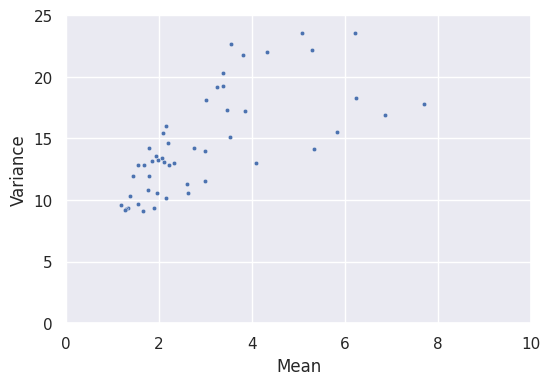

In [192]:
plot_mean_variance_static(test_df, 50, xrange=(0,10), yrange=(0,25))

### Compute + plot mean and variance

In [12]:
mean_variance_df_degs = compute_mean_variance_df(adata_degs)

In [30]:
mean_variance_df_degs.shape

(2780780, 4)

In [13]:
mean_variance_df_degs.head()

TF KO    Gene      Mean   Variance
0  POU5F1B    SIX3  4.760942  25.095072
1   HOXD13    SIX3  4.428304  24.835049
2   ZNF396    SIX3  4.225697  24.568214
3   ZNF521    SIX3  3.982568  24.139648
4   POU5F1  TBC1D9  5.078688  23.551092

Tables

In [83]:
mean_variance_df_degs_100 = mean_variance_df_degs.head(100).copy()

In [86]:
mean_variance_df_degs_1000 = mean_variance_df_degs.head(1000).copy()

In [190]:
mean_variance_df_degs_1000["TF KO"].value_counts().head(10)

TF KO
POU5F1     113
PHF20       83
POU5F1B     66
POU3F2      51
HOXD13      32
ZNF396      31
ZNF521      31
DNMT1       30
NANOGP8     17
PRDM14      13
Name: count, dtype: int64

In [191]:
mean_variance_df_degs_1000["Gene"].value_counts().head(10)

Gene
GREB1L             35
CDH6               20
PRTG               17
ENSG00000289426    16
SIX3               16
ZIC1               15
PAMR1              15
DACH1              14
LINC02334          13
CDH9               13
Name: count, dtype: int64

Interactive plot

In [7]:
plot_mean_variance_interactive(mean_variance_df_degs, 1000)

Static plots

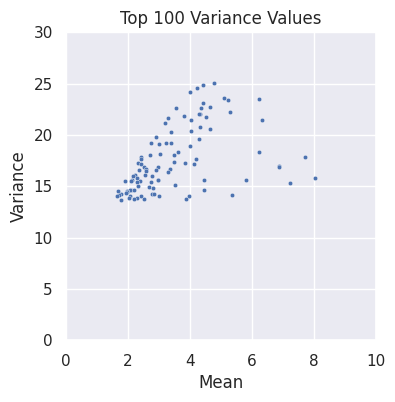

In [188]:
plot_mean_variance_static(mean_variance_df_degs, 100, xrange=(0,10), yrange=(0,30),
                          title="Top 100 Variance Values", fig_size=(4,4))

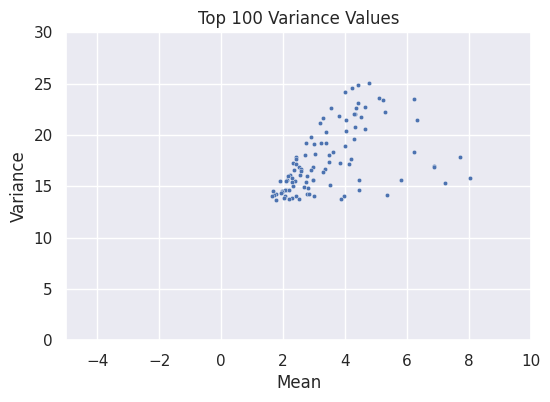

In [186]:
plot_mean_variance_static(mean_variance_df_degs, 100, xrange=(-5,10), yrange=(0,30),
                          title="Top 100 Variance Values")

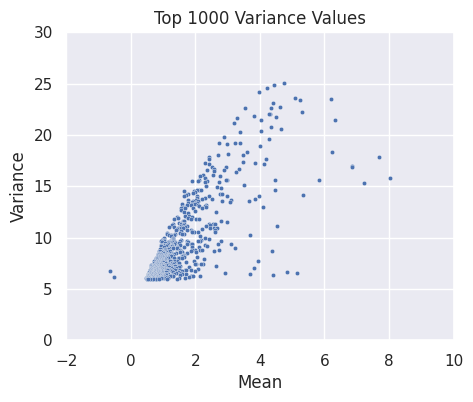

In [189]:
plot_mean_variance_static(mean_variance_df_degs, 1000, xrange=(-2,10), yrange=(0,30),
                          title="Top 1000 Variance Values", fig_size=(5,4))

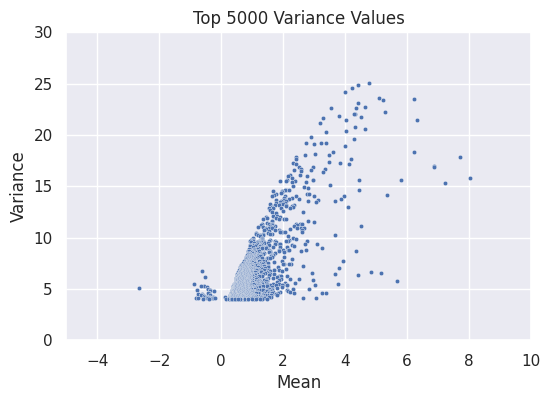

In [173]:
plot_mean_variance_static(mean_variance_df_degs, 5000, xrange=(-5,10), yrange=(0,30),
                          title="Top 5000 Variance Values")

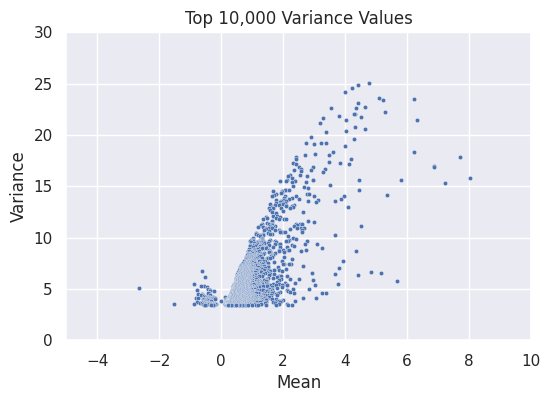

In [176]:
plot_mean_variance_static(mean_variance_df_degs, 10000, xrange=(-5,10), yrange=(0,30),
                          title="Top 10,000 Variance Values")

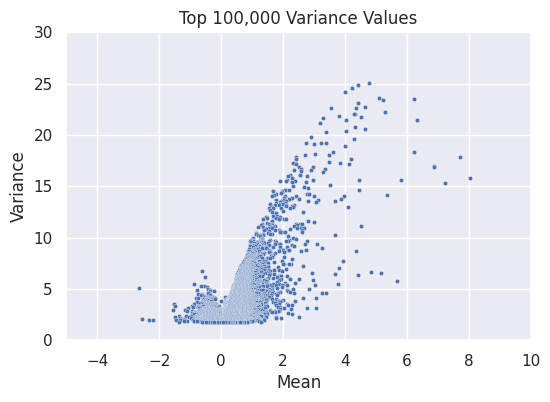

In [180]:
plot_mean_variance_static(mean_variance_df_degs, 100000, xrange=(-5,10), yrange=(0,30),
                          title="Top 100,000 Variance Values")

In [183]:
mean_variance_df_degs.head(100000).tail(10)

TF KO             Gene      Mean  Variance
99990     IRF4            SETD6  0.209115  1.809081
99991    HOXA7            ZFHX4  0.062558  1.809077
99992   HOXD13           LRRC4C  1.292396  1.809069
99993     ETV5           CDC14A  0.273346  1.809062
99994    TBPL2            PROS1  0.150668  1.809061
99995  NANOGNB          ADAMTS6  0.247193  1.809057
99996     PBX1         LNC-LBCS  0.217151  1.809056
99997    FOXQ1              SP8  0.141651  1.809047
99998   ZBTB22  ENSG00000250993  0.135495  1.809047
99999  ZNF780A             CHD3  0.062155  1.809043

For top TF KOs, check for overlap between 1) genes with high variance and 2) known TF targets from DoRothEA and CollecTRI

In [33]:
def build_tf_target_dict():
    all_dicts = list()
    # CollecTRI
    collectri_df = dc.op.collectri(organism='human')
    collectri_dict = dict()
    for tf, gene in collectri_df.iloc[:,:2].itertuples(index=False, name=None):
        if tf not in collectri_dict:
            collectri_dict[tf] = set()
        collectri_dict[tf].add(gene)
    all_dicts.append(collectri_dict)
    
    # DoRothEA levels A and B
    dorothea_df = dc.op.dorothea(organism="human", levels=["A", "B"])
    dorothea_dict = dict()
    for tf, gene in dorothea_df.iloc[:,:2].itertuples(index=False, name=None):
        if tf not in dorothea_dict:
            dorothea_dict[tf] = set()
        dorothea_dict[tf].add(gene)
    all_dicts.append(dorothea_dict)
    
    tf_target_dict = dict()
    all_tfs = {tf for target_dict in all_dicts for tf in target_dict.keys()}
    for tf in all_tfs:
        genes = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]}
        tf_target_dict[tf] = genes
    return tf_target_dict

In [34]:
dorothea_collectri_dict = build_tf_target_dict()

In [35]:
print(dorothea_collectri_dict["POU5F1"])

{'PDGFRA', 'CDKN2A', 'CGB8', 'JADE1', 'MYOD1', 'MMP2', 'CRIPTO', 'NR0B1', 'MMP13', 'CCNF', 'TOR1AIP2', 'TERF1', 'CCND1', 'SOX2', 'WNT3', 'ZIC3', 'AFP', 'DDC', 'BIRC5', 'SPP1', 'ITGA6', 'DLX5', 'HES3', 'GATA6', 'SALL4', 'PAX6', 'HSPD1', 'SEMA6A', 'AKT1', 'IGF2-AS', 'BMP4', 'TBX18', 'TBXT', 'DNMT1', 'RLIM', 'GATA4', 'NES', 'JMJD1C', 'ESRG', 'HES6', 'HLX', 'USP44', 'AHR', 'DPPA4', 'MMP9', 'GADD45A', 'CDKN1A', 'CDX2', 'NANOG', 'MESP1', 'EED', 'PPP1CC', 'KDM3A', 'PRKN', 'BRCA1', 'TDGF1', 'FGF8', 'TET2', 'E2F3', 'LEFTY1', 'L1TD1', 'FOXA2', 'CXCR4', 'DKK1', 'SLC2A3', 'GJA1', 'UTF1', 'PHC1', 'FGF4', 'THY1', 'CNTF', 'hsa-miR-145', 'ACTG2', 'TUG1', 'KDM4C', 'SOX17', 'ZFP42', 'SRA1', 'ZSCAN10', 'EOMES', 'TYR', 'FBXO15', 'PPP1R8', 'SP5', 'ID2', 'TET1', 'CGA', 'POU5F1', 'SLC22A3', 'STK40', 'CCN2', 'TCL1A', 'LEFTY2', 'MEIS1', 'FOXA1', 'CDH1'}


In [15]:
mean_variance_df_degs_1000 = mean_variance_df_degs.head(1000).copy()
mean_variance_df_degs_1000.head()

TF KO    Gene      Mean   Variance
0  POU5F1B    SIX3  4.760942  25.095072
1   HOXD13    SIX3  4.428304  24.835049
2   ZNF396    SIX3  4.225697  24.568214
3   ZNF521    SIX3  3.982568  24.139648
4   POU5F1  TBC1D9  5.078688  23.551092

In [16]:
top_tf_ko_df_1000 = mean_variance_df_degs_1000["TF KO"].value_counts().head(10)
top_tf_ko_df_1000

TF KO
POU5F1     113
PHF20       83
POU5F1B     66
POU3F2      51
HOXD13      32
ZNF396      31
ZNF521      31
DNMT1       30
NANOGP8     17
PRDM14      13
Name: count, dtype: int64

In [26]:
top_10_tf_kos_1000 = top_tf_ko_df_1000.index.to_list()
print(top_10_tf_kos_1000)

['POU5F1', 'PHF20', 'POU5F1B', 'POU3F2', 'HOXD13', 'ZNF396', 'ZNF521', 'DNMT1', 'NANOGP8', 'PRDM14']


In [36]:
def build_tf_ko_high_variance_gene_dict(mean_variance_df, n_tf_kos):
    # Get n_tf_kos TF KOs with greatest number of high variance genes
    tf_ko_value_counts = mean_variance_df["TF KO"].value_counts().head(n_tf_kos)
    top_tf_kos = tf_ko_value_counts.index.to_list()
    # Build dict of TF KOs and high variance genes
    high_var_gene_dict = dict()
    for tf_ko in top_tf_kos:
        high_var_genes = mean_variance_df[mean_variance_df["TF KO"] == tf_ko]["Gene"].to_list()
        high_var_gene_dict[tf_ko] = set(high_var_genes)
    return high_var_gene_dict

def print_high_variance_gene_targets(mean_variance_df, n_tf_kos, tf_target_dict=None):
    # Get known TF targets
    if tf_target_dict is not None:
        tf_target_dict = build_dorothea_collectri_dict()
    # Build dict of TF KOs and high variance genes
    high_var_gene_dict = build_tf_ko_high_variance_gene_dict(mean_variance_df, n_tf_kos)
    # For each TF KO, find intersection of high variance and target genes
    for tf_ko in high_var_gene_dict:
        if tf_ko not in tf_target_dict:
            print(f"TF KO {tf_ko} not found in DoRothEA or CollecTRI")
        else:
            high_var_targets = tf_target_dict[tf_ko] & high_var_gene_dict[tf_ko]
            if high_var_targets:
                print(f"TF KO {tf_ko} has {len(high_var_targets)} target genes with "
                    f"high variance: {', '.join(high_var_targets)}")
            else:
                print(f"TF KO {tf_ko} has 0 target genes with high variance")

In [37]:
print_high_variance_gene_targets(mean_variance_df_degs_1000, 10, dorothea_collectri_dict)

TF KO POU5F1 has 2 target genes with high variance: GADD45A, ID2
TF KO PHF20 has 0 target genes with high variance
TF KO POU5F1B not found in DoRothEA or CollecTRI
TF KO POU3F2 has 0 target genes with high variance
TF KO HOXD13 has 1 target genes with high variance: DACH1
TF KO ZNF396 not found in DoRothEA or CollecTRI
TF KO ZNF521 has 0 target genes with high variance
TF KO DNMT1 has 1 target genes with high variance: RUNX1
TF KO NANOGP8 has 0 target genes with high variance
TF KO PRDM14 has 1 target genes with high variance: WNT5B


Perform overrepresentation analysis (ORA) using list of top 100 genes to see which pathways are enriched

In [38]:
mean_variance_df_degs_1000["Gene"].value_counts().head(10)

Gene
GREB1L             35
CDH6               20
PRTG               17
ENSG00000289426    16
SIX3               16
ZIC1               15
PAMR1              15
DACH1              14
LINC02334          13
CDH9               13
Name: count, dtype: int64

In [ ]:
import gseapy as gp

In [43]:
top_100_genes_list = mean_variance_df_degs_1000["Gene"].value_counts().head(100).index.to_list()
background_genes_list = list(degs_padj)
print(f"Number of high-variance genes: {len(top_100_genes_list)}")
print(f"Number of background genes: {len(background_genes_list)}")

Number of high-variance genes: 100
Number of background genes: 4265


In [45]:
enr_top_100 = gp.enrichr(gene_list=top_100_genes_list, gene_sets='MSigDB_Hallmark_2020',
                         organism='human', background=background_genes_list, outdir=None)
ora_results_top_100 = enr_top_100.results

In [48]:
display(ora_results_top_100)

Gene_set                               Term   P-value  \
0   MSigDB_Hallmark_2020         Wnt-beta Catenin Signaling  0.041233   
1   MSigDB_Hallmark_2020              Inflammatory Response  0.172014   
2   MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition  0.194771   
3   MSigDB_Hallmark_2020                    heme Metabolism  0.258475   
4   MSigDB_Hallmark_2020                 Hedgehog Signaling  0.299864   
5   MSigDB_Hallmark_2020                    Spermatogenesis  0.421389   
6   MSigDB_Hallmark_2020                  KRAS Signaling Dn  0.510434   
7   MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB  0.575862   
8   MSigDB_Hallmark_2020                  KRAS Signaling Up  0.585892   
9   MSigDB_Hallmark_2020                         Myogenesis  0.605251   
10  MSigDB_Hallmark_2020                     UV Response Up  0.614592   
11  MSigDB_Hallmark_2020                        p53 Pathway  0.658113   
12  MSigDB_Hallmark_2020                  Androgen Response  0.666215   
13  MSigDB_Hallmark_2020              Fatty Acid Metabolism  0.674126   
14  MSigDB_Hallmark_2020                          Apoptosis  0.696764   
15  MSigDB_Hallmark_2020               IL-2/STAT5 Signaling  0.710983   
16  MSigDB_Hallmark_2020                            Hypoxia  0.724542   
17  MSigDB_Hallmark_2020             Estrogen Response Late  0.731083   
18  MSigDB_Hallmark_2020            Estrogen Response Early  0.761553   
19  MSigDB_Hallmark_2020                         Glycolysis  0.767224   
20  MSigDB_Hallmark_2020                    Apical Junction  0.783446   
21  MSigDB_Hallmark_2020                     UV Response Dn  0.833913   
22  MSigDB_Hallmark_2020                   mTORC1 Signaling  0.913663   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0           0.858060            0                     0    7.062925   
1           0.858060            0                     0    2.812925   
2           0.858060            0                     0    2.046724   
3           0.858060            0                     0    2.104592   
4           0.858060            0                     0    2.994949   
5           0.858060            0                     0    1.902204   
6           0.858060            0                     0    1.440613   
7           0.858060            0                     0    1.191919   
8           0.858060            0                     0    1.158530   
9           0.858060            0                     0    1.097023   
10          0.858060            0                     0    1.068635   
11          0.858060            0                     0    0.946051   
12          0.858060            0                     0    0.924804   
13          0.858060            0                     0    0.904480   
14          0.858060            0                     0    0.848485   
15          0.858060            0                     0    0.814815   
16          0.858060            0                     0    0.783686   
17          0.858060            0                     0    0.768986   
18          0.858060            0                     0    0.702962   
19          0.858060            0                     0    0.691077   
20          0.858060            0                     0    0.657688   
21          0.871818            0                     0    0.558422   
22          0.913663            0                     0    0.406441   

    Combined Score           Genes  
0        22.520168      WNT5B;FZD8  
1         4.951254      BTG2;ITGB8  
2         3.348300  CDH6;FBN2;FZD8  
3         2.847418      KAT2B;BTG2  
4         3.607198           NRCAM  
5         1.643884           CLVS1  
6         0.968803            BTG2  
7         0.657804            BTG2  
8         0.619374            SOX9  
9         0.550828             FST  
10        0.520208            BTG2  
11        0.395807            BTG2  
12        0.375603             MAF  
13        0.356670           ACSM3  
14 

# UMAP

In [2]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [3]:
def pca(adata):
    adata = adata.copy()
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
    return adata

In [235]:
def build_cluster_by_tf_ko_df(adata, leiden_res_key: str):
    """
    Create DataFrame where rows are Leiden clusters, cols are TF KOs, 
    and entries are the number of cells corresponding to a given TF KO in a cluster.
    """
    df = adata.obs[[leiden_res_key, "gene_target"]]
    # Count occurrences of each perturbation in each cluster
    cluster_by_tf_ko_df = \
        df.groupby([leiden_res_key, "gene_target"]).size().unstack(fill_value=0)
    cluster_by_tf_ko_df.index.name = "leiden_cluster"
    return cluster_by_tf_ko_df

def build_tf_ko_by_cluster_df(adata, leiden_res_key: str):
    """
    Create DataFrame where rows are TF KOs, cols are Leiden clusters, 
    and entries are the number of cells corresponding to a given TF KO in a cluster.
    """
    df = adata.obs[[leiden_res_key, "gene_target"]]
    # Count occurrences of each perturbation in each cluster
    tf_ko_by_cluster_df = \
        df.groupby([leiden_res_key, "gene_target"]).size().unstack(fill_value=0)
    tf_ko_by_cluster_df.index.name = "leiden_cluster"
    tf_ko_by_cluster_df = tf_ko_by_cluster_df.T
    return tf_ko_by_cluster_df

In [285]:
def plot_n_tf_kos_per_umap_cluster(adata, leiden_res_key: str, title=None):
    """
    Plot number of unique TF KOs per UMAP Leiden cluster.
    leiden_res_key = string such as 'leiden_res_0.50'
    """
    df = adata.obs[[leiden_res_key, "gene_target"]]
    cluster_nums = [i for i in range(df[leiden_res_key].nunique())]
    n_tf_kos_per_cluster = \
        [df[df[leiden_res_key] == str(i)]['gene_target'].nunique() 
         for i in cluster_nums]
    ax = sns.barplot(x=cluster_nums, y=n_tf_kos_per_cluster)
    ax.set_xlabel("UMAP Leiden cluster", fontsize=14)
    ax.set_ylabel("Number of unique TF KOs in cluster", fontsize=14)
    ax.bar_label(ax.containers[0], fontsize=12, rotation=90, padding=5)
    ax.set_ylim(0, 750)
    if title:
        ax.set_title(title, fontsize=14)

def plot_n_cells_per_umap_cluster(adata, leiden_res_key: str, ymax=None, title=None):
    """
    Plot number of cells per UMAP Leiden cluster.
    leiden_res_key = string such as 'leiden_res_0.50'
    """
    plt.rcParams.update({"font.size": 12})
    df = adata.obs[[leiden_res_key, "gene_target"]]
    ax = sns.barplot(df[leiden_res_key].value_counts(), color="green")
    ax.set_xlabel("UMAP Leiden cluster", fontsize=14)
    ax.set_ylabel("Number of cells in cluster", fontsize=14)
    ax.bar_label(ax.containers[0], fontsize=12, rotation=90, padding=5)
    if ymax:
        ax.set_ylim(0, ymax)
    if title:
        ax.set_title(title, fontsize=14)

In [243]:
def cluster_specific_tf_kos(cluster_summary_df, frac_in_top_cluster=0.5):
    """
    Create DataFrame of the top cluster in which each TF KO is represented.
    """
    tf_ko_sums = cluster_summary_df.sum(axis=0)
    tf_ko_max_vals = cluster_summary_df.max(axis=0)
    frac_in_cluster = tf_ko_max_vals / tf_ko_sums
    selected_tf_kos = frac_in_cluster[frac_in_cluster >= frac_in_top_cluster].index
    top_cluster_per_tf_ko = cluster_summary_df[selected_tf_kos].idxmax(axis=0)
    cluster_specific_tf_ko_df = pd.DataFrame({
        'TF KO': selected_tf_kos,
        'Top Cluster': top_cluster_per_tf_ko,
        'Fraction in Top Cluster': 
        frac_in_cluster[selected_tf_kos].values}).set_index('TF KO')
    return cluster_specific_tf_ko_df

def print_cluster_tf_ko_summary(cluster_summary_df, frac_list=[0.5, 0.3, 0.25]):
    """
    Print summary of what percent of TF KO cells are in a single cluster for each TF KO.
    """
    print(f"{cluster_summary_df.shape[1]} total TF KOs")
    for frac in frac_list:
        cluster_specific_tf_ko_df = cluster_specific_tf_kos(cluster_summary_df, 
                                                            frac_in_top_cluster=frac)
        print(f"{cluster_specific_tf_ko_df.shape[0]} TF KOs have "
              f">= {frac*100:.0f}% of cells in a single cluster")

## HVGs as features

In [6]:
adata_hvgs = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_hvgs, n_top_genes=2000, flavor='seurat_v3', layer='counts')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


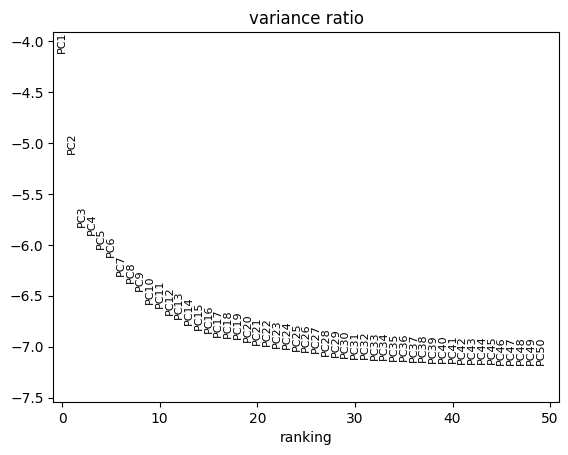

In [7]:
adata_hvgs = pca(adata_hvgs)

In [8]:
sc.pp.neighbors(adata_hvgs, n_pcs=30)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:12)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [9]:
sc.tl.umap(adata_hvgs)

computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


In [10]:
sc.tl.leiden(adata_hvgs, key_added=f"leiden_res_0.40", resolution=0.4)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:37)


In [46]:
for res in (0.25, 0.5, 0.75, 1):
    sc.tl.leiden(adata_hvgs, key_added=f"leiden_res_{res:4.2f}", resolution=res)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res_0.25', the cluster labels (adata.obs, categorical) (0:00:23)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:31)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:32)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:35)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


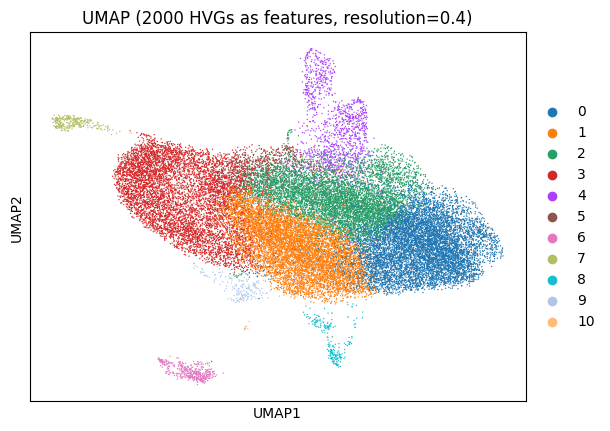

In [38]:
sc.pl.umap(adata_hvgs, color=["leiden_res_0.40"], title="UMAP (2000 HVGs as features, resolution=0.4)")

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


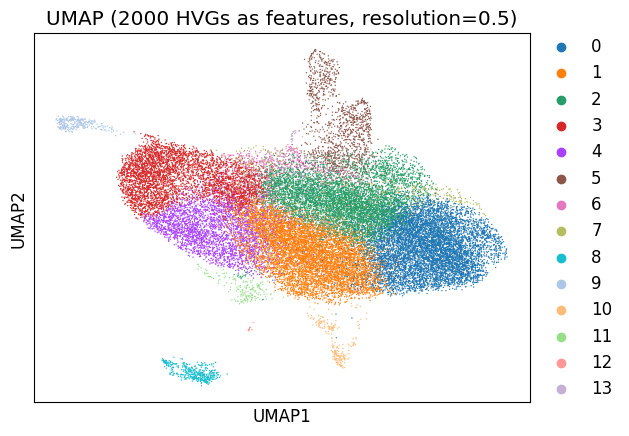

In [262]:
sc.pl.umap(adata_hvgs, color=["leiden_res_0.50"], title="UMAP (2000 HVGs as features, resolution=0.5)")

In [11]:
# sc.pl.umap(adata_hvgs, color=["leiden_res_0.75", "leiden_res_1.00"], wspace=0.3, size=2)

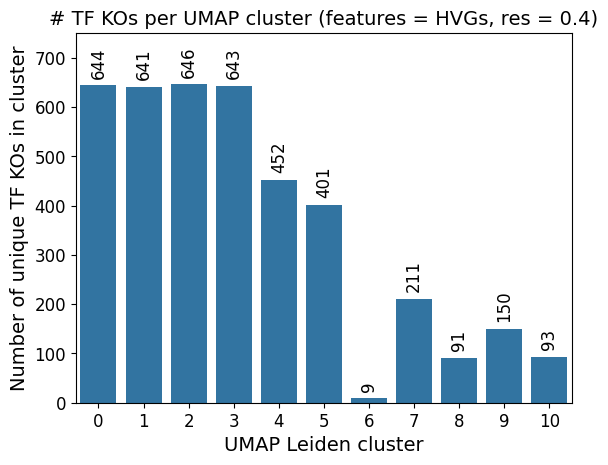

In [281]:
plot_n_tf_kos_per_umap_cluster(adata_hvgs, "leiden_res_0.40", ymax=750,
                               title="# TF KOs per UMAP cluster (features = HVGs, res = 0.4)")

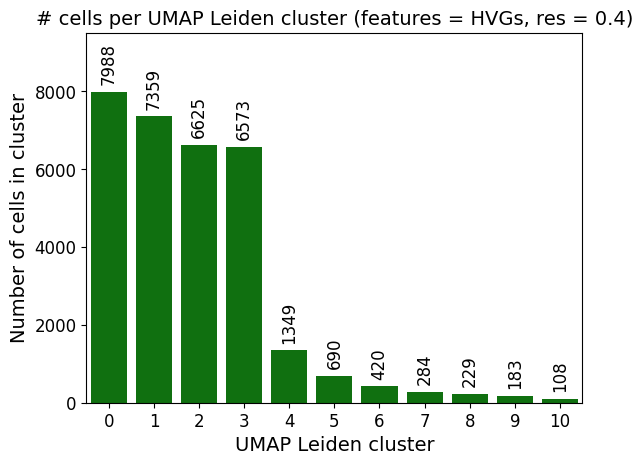

In [288]:
plot_n_cells_per_umap_cluster(adata_hvgs, "leiden_res_0.40", ymax=9500,
                              title="# cells per UMAP Leiden cluster (features = HVGs, res = 0.4)")

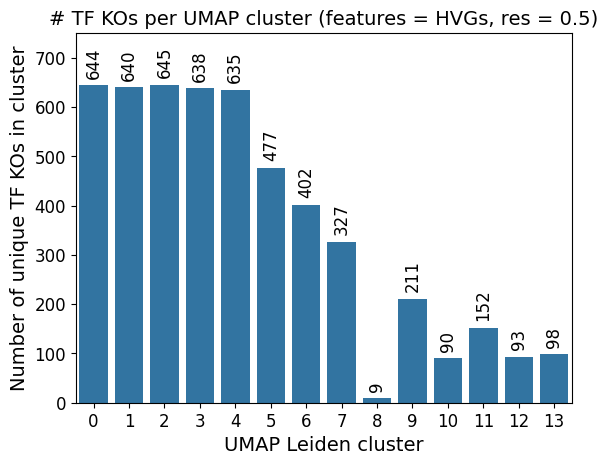

In [289]:
plot_n_tf_kos_per_umap_cluster(adata_hvgs, "leiden_res_0.50", 
                               "# TF KOs per UMAP cluster (features = HVGs, res = 0.5)")

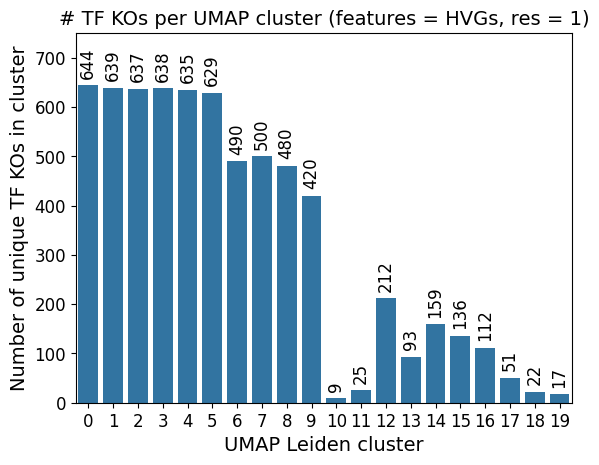

In [290]:
plot_n_tf_kos_per_umap_cluster(adata_hvgs, "leiden_res_1.00", 
                               "# TF KOs per UMAP cluster (features = HVGs, res = 1)")

In [244]:
print_cluster_tf_ko_summary(build_cluster_by_tf_ko_df(adata_hvgs, "leiden_res_0.40"))

652 total TF KOs
21 TF KOs have >= 50% of cells in a single cluster
413 TF KOs have >= 30% of cells in a single cluster
634 TF KOs have >= 25% of cells in a single cluster


In [267]:
umap_hvgs_df_res4 = build_tf_ko_by_cluster_df(adata_hvgs, "leiden_res_0.40")
umap_hvgs_df_res4.head()

leiden_cluster   0   1   2   3  4  5  6  7  8  9  10
gene_target                                         
ADNP2           15  10   5   8  2  0  0  0  1  0   0
AEBP1            7   6   7   8  0  1  0  0  0  0   0
AHR             14  11  10  18  0  1  0  0  1  0   0
AIRE            17  21  11  10  0  1  0  0  0  1   0
AKAP8            3   9  13   8  1  2  0  2  0  1   2

In [268]:
umap_hvgs_df_res4[umap_hvgs_df_res4["6"] > 0]

leiden_cluster  0   1   2   3  4  5   6  7  8  9  10
gene_target                                         
AKAP8L          0   0   0   0  1  0  44  0  0  0   0
CCDC17          0   0   0   0  0  0  35  0  0  0   0
FAM200B         7  14  16  19  0  5   3  0  1  0   0
MSANTD4         0   0   1   0  0  0  69  0  0  0   0
MTERF4          0   0   1   0  0  0  58  0  0  0   0
PIN1            0   0   0   0  0  0  77  0  0  0   0
RBCK1           0   0   1   0  0  0  69  0  0  0   0
SNAPC5          0   0   0   0  0  0  41  0  0  0   0
ZBED6           0   0   0   0  0  0  24  1  0  0   0

In [270]:
umap_hvgs_df_res5 = build_tf_ko_by_cluster_df(adata_hvgs, "leiden_res_0.50")
umap_hvgs_df_res5[umap_hvgs_df_res5["8"] > 0]

leiden_cluster  0   1   2   3  4  5  6  7   8  9  10  11  12  13
gene_target                                                     
AKAP8L          0   0   0   0  0  1  0  0  44  0   0   0   0   0
CCDC17          0   0   0   0  0  0  0  0  35  0   0   0   0   0
FAM200B         8  12  14  13  8  0  5  0   3  0   1   0   0   1
MSANTD4         0   0   1   0  0  0  0  0  69  0   0   0   0   0
MTERF4          0   0   1   0  0  0  0  0  58  0   0   0   0   0
PIN1            0   0   0   0  0  0  0  0  77  0   0   0   0   0
RBCK1           0   0   0   0  1  0  0  0  69  0   0   0   0   0
SNAPC5          0   0   0   0  0  0  0  0  41  0   0   0   0   0
ZBED6           0   0   0   0  0  0  0  0  24  1   0   0   0   0

In [271]:
hvg_pkl_filename = "/home/ranwyl/results_tf_project/umap_clusters_hvgs_res0pt4.pkl"
umap_hvgs_df_res4.to_pickle(hvg_pkl_filename)

In [3]:
umap_hvgs_summary = pd.read_pickle("/home/ranwyl/results_tf_project/umap_clusters_hvgs_res0pt4.pkl")
umap_hvgs_summary.head()

leiden_cluster   0   1   2   3  4  5  6  7  8  9  10
gene_target                                         
ADNP2           15  10   5   8  2  0  0  0  1  0   0
AEBP1            7   6   7   8  0  1  0  0  0  0   0
AHR             14  11  10  18  0  1  0  0  1  0   0
AIRE            17  21  11  10  0  1  0  0  0  1   0
AKAP8            3   9  13   8  1  2  0  2  0  1   2

In [7]:
umap_hvgs_summary["6"][umap_hvgs_summary["6"] > 0]

gene_target
AKAP8L     44
CCDC17     35
FAM200B     3
MSANTD4    69
MTERF4     58
PIN1       77
RBCK1      69
SNAPC5     41
ZBED6      24
Name: 6, dtype: int64

In [11]:
umap_hvgs_summary.loc["FAM200B"]

leiden_cluster
0      7
1     14
2     16
3     19
4      0
5      5
6      3
7      0
8      1
9      0
10     0
Name: FAM200B, dtype: int64

## DEGs with |LFC| > 0.25 as features

In [51]:
with open("/home/ranwyl/results_tf_project/degs_padj_final.txt") as f:
    degs_25 = {deg.strip() for deg in f.readlines()}
adata_degs_25 = adata_tfs[:, adata_tfs.var.index.isin(degs_25)].copy()
adata_degs_25

AnnData object with n_obs × n_vars = 31808 × 4265
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

computing PCA
    with n_comps=50
    finished (0:00:05)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


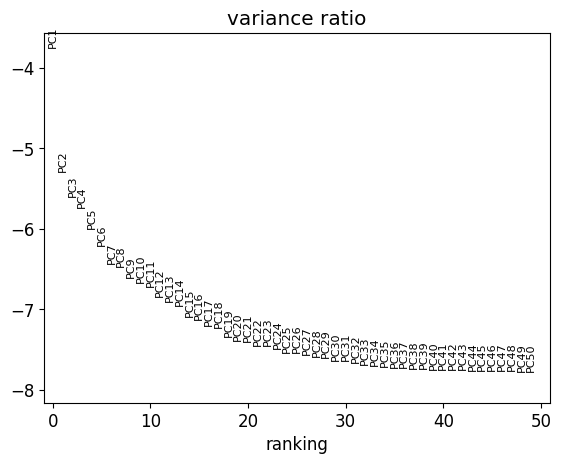

In [52]:
adata_degs_25 = pca(adata_degs_25)

We will use the first 30 PCs for KNN

In [53]:
sc.pp.neighbors(adata_degs_25, n_pcs=30)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:01)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [54]:
sc.tl.umap(adata_degs_25)

computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


In [25]:
sc.tl.leiden(adata_degs_25, key_added=f"leiden_res_0.50", resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:27)


In [55]:
for res in (0.4, 0.5, 0.75, 1):
    sc.tl.leiden(adata_degs_25, key_added=f"leiden_res_{res:4.2f}", resolution=res)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:34)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:26)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:38)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:23)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


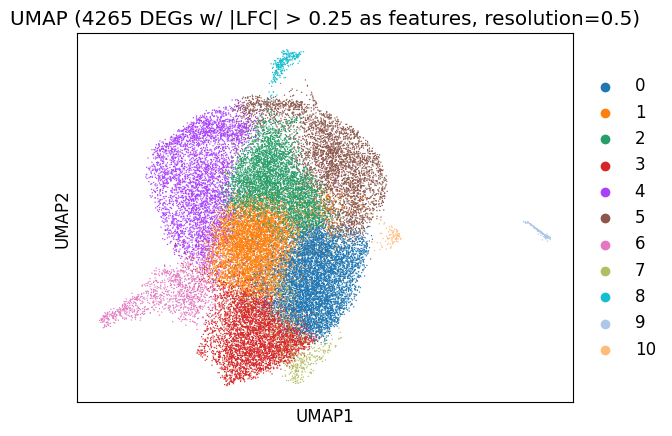

In [256]:
sc.pl.umap(adata_degs_25, color=["leiden_res_0.50"], 
           title="UMAP (4265 DEGs w/ |LFC| > 0.25 as features, resolution=0.5)")

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


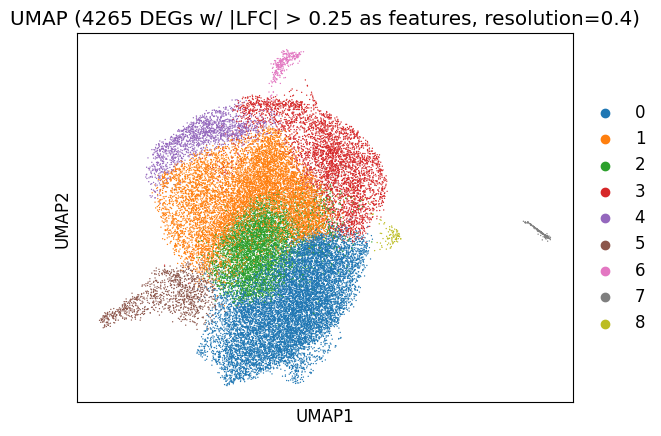

In [257]:
sc.pl.umap(adata_degs_25, color=["leiden_res_0.40"], 
           title="UMAP (4265 DEGs w/ |LFC| > 0.25 as features, resolution=0.4)")

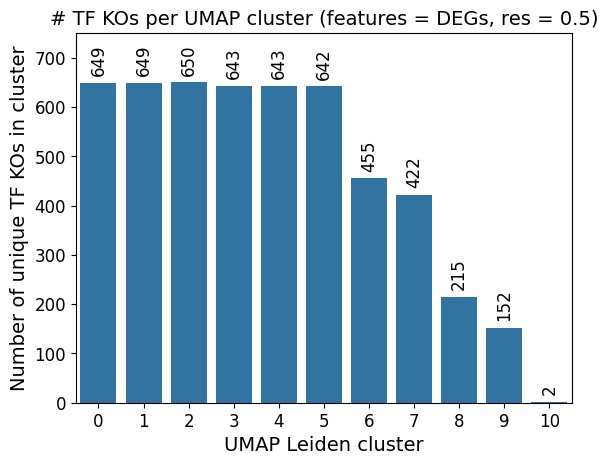

In [295]:
plot_n_tf_kos_per_umap_cluster(adata_degs_25, "leiden_res_0.50", 
                               "# TF KOs per UMAP cluster (features = DEGs, res = 0.5)")

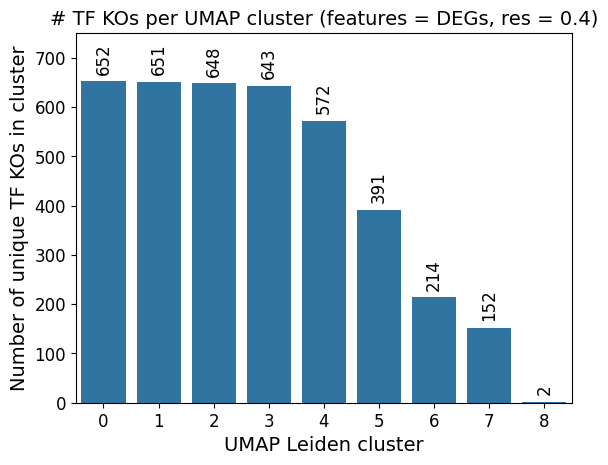

In [297]:
plot_n_tf_kos_per_umap_cluster(adata_degs_25, "leiden_res_0.40", 
                               "# TF KOs per UMAP cluster (features = DEGs, res = 0.4)")

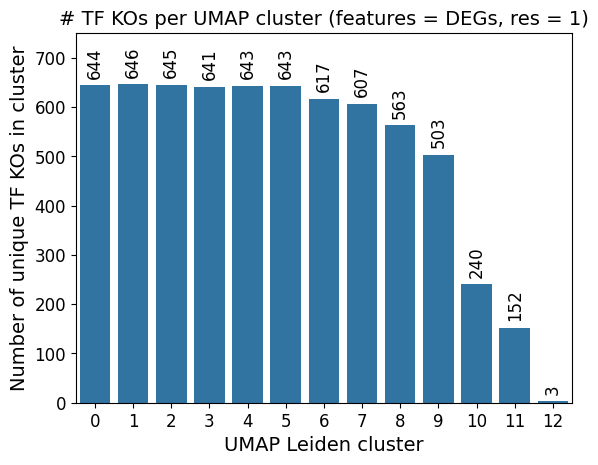

In [296]:
plot_n_tf_kos_per_umap_cluster(adata_degs_25, "leiden_res_1.00", 
                               "# TF KOs per UMAP cluster (features = DEGs, res = 1)")

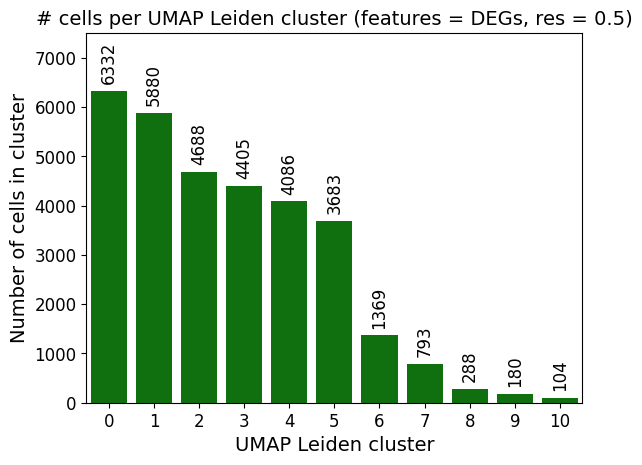

In [299]:
plot_n_cells_per_umap_cluster(adata_degs_25, "leiden_res_0.50", ymax=7500,
                              title="# cells per UMAP Leiden cluster (features = DEGs, res = 0.5)")

In [251]:
print_cluster_tf_ko_summary(build_cluster_by_tf_ko_df(adata_degs_25, "leiden_res_0.50"))

652 total TF KOs
11 TF KOs have >= 50% of cells in a single cluster
100 TF KOs have >= 30% of cells in a single cluster
322 TF KOs have >= 25% of cells in a single cluster


In [300]:
umap_degs_summary_display = build_tf_ko_by_cluster_df(adata_degs_25, "leiden_res_0.50")
umap_degs_summary_display.head()

leiden_cluster   0   1   2  3   4   5  6  7  8  9  10
gene_target                                          
ADNP2            7   9   1  8   3   8  2  2  0  1   0
AEBP1            7   4   5  5   4   4  0  0  0  0   0
AHR              5  10  12  8   8  10  0  0  0  2   0
AIRE            14  10   9  9  11   8  0  0  0  0   0
AKAP8           11   9   6  0   6   6  1  0  2  0   0

In [255]:
umap_degs_summary_display[umap_degs_summary_display["10"] > 0]

leiden_cluster  0   1   2  3   4   5  6  7  8  9   10
gene_target                                          
DNMT1           6   7  11  3   5  13  1  1  0  0  103
SETDB1          9  28  13  2  19  15  0  0  1  0    1

In [301]:
deg_pkl_filename = "/home/ranwyl/results_tf_project/umap_clusters_degs_res0pt5.pkl"
umap_degs_summary_display.to_pickle(deg_pkl_filename)

In [273]:
adata_degs_25_summary = build_cluster_by_tf_ko_df(adata_degs_25, "leiden_res_0.50")

In [274]:
display(adata_degs_25_summary[["POU5F1", "NANOG"]])

gene_target     POU5F1  NANOG
leiden_cluster               
0                    3      5
1                    0      3
2                    3      5
3                    0      5
4                    1      7
5                    1      5
6                   92     61
7                    0      1
8                    0      0
9                    0      0
10                   0      0

In [275]:
print_cluster_tf_ko_summary(adata_degs_25_summary)

652 total TF KOs
11 TF KOs have >= 50% of cells in a single cluster
100 TF KOs have >= 30% of cells in a single cluster
322 TF KOs have >= 25% of cells in a single cluster


### Top 20 genes that contribute to first 2 PCs

Get the top 20 genes that contribute to the first 2 PCs. Genes that contribute positively have expression that increases across the PC axis, and genes that contribute negatively have expression that decreases.

In [11]:
def get_top_pca_genes(adata, top_n):
    genes = adata.var_names
    pc_loadings = adata.varm["PCs"]
    pc1_df = pd.DataFrame({'gene': genes, 'loading': pc_loadings[:, 0]})
    pc2_df = pd.DataFrame({'gene': genes, 'loading': pc_loadings[:, 1]})
    pc1_genes, pc2_genes = list(), list()
    for df, lst in zip((pc1_df, pc2_df), (pc1_genes, pc2_genes)):
        top_pos = df.nlargest(top_n, 'loading')['gene'].tolist()
        lst.append(top_pos)
        top_neg = df.nsmallest(top_n, 'loading')['gene'].tolist()
        lst.append(top_neg)
    return pc1_genes, pc2_genes

In [ ]:
pc1_top_genes, pc2_top_genes = get_top_pca_genes(adata_tfs_pca, 20)
pc1_pos_genes, pc1_neg_genes = pc1_top_genes[0], pc1_top_genes[1]
pc2_pos_genes, pc2_neg_genes = pc2_top_genes[0], pc2_top_genes[1]

In [ ]:
print(f"PC1 top 20 positively contributing genes: {pc1_pos_genes}")
print(f"PC1 top 20 negatively contributing genes: {pc1_neg_genes}")
print(f"PC2 top 20 positively contributing genes: {pc2_pos_genes}")
print(f"PC2 top 20 negatively contributing genes: {pc2_neg_genes}")

# Other Analyses